In [1]:
# from torchcam.associativeNN import aCAM_NOR
import torch
import torch.nn as nn
import numpy as np
# from scipy.signal import correlate as scipy_autocorrelate
# # from scipy.signal import correlation_lags as scipy_correlation_lags
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
# import torch.nn as nn
import matplotlib.cm as cm
# from matplotlib.ticker import LinearLocator
# import ipywidgets as widgets
# from ipywidgets import interact, fixed
# from IPython.display import display
from inspect import getargspec
# from matplotlib import rc_params as rc
import os
import sys
dir_name = os.getcwd()
parent_dir_name = os.path.dirname(dir_name)
sys.path.insert(0, parent_dir_name)
from modules.continuous_model import CAMSimilarity
from sklearn.metrics import r2_score

Fitting DRAM MAC
If temporal encoding: use only the max X value 0.9 V

In [ ]:

data = np.load("non-linearity.npy", allow_pickle=True).item()

Y, X = np.meshgrid(data['Vstore'], data['Vin'])
Z = data['Iout'].T * 1e+6

# # Plot the 3D figure of the fitted function and the residuals.
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')

# plt.show()

def get_basis(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis.append(x**j * y**i)
    return basis

def poly_torch(x, y, c):
    """Compute the polynomial basis and sum the elements weighted by the coefficients."""
    max_order = int((2 * len(c))**0.5 - 1)
    basis_sum = torch.zeros_like(x)
    idx = 0
    for i in range(max_order+1):
        for j in range(max_order - i + 1):
            basis_sum += c[idx] * (x**j) * (y**i)
            # print(j, i)
            idx += 1
    return basis_sum

# # Linear with X
# X = X.max()*np.ones_like(X)
# Z = np.expand_dims(Z[-1], axis=0).repeat(Z.shape[0], axis=0)

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
x, y = X.ravel(), Y.ravel()
### If temporal encoding, x always Vds=0.9 V ###
offset = 0.45
Y = Y-offset
x, y, Z = X[-1], Y[-1], Z[-1]
X, Y = X[-1], Y[-1]

# Maximum order of polynomial term in the basis.
max_order = 3
basis = get_basis(x, y, max_order)
# Linear, least-squares fit.
A = np.vstack(basis).T
b = Z.ravel()
c, r, rank, s = np.linalg.lstsq(A, b, rcond=None)

print('Fitted parameters:')
print(c)

fit = poly_torch(torch.tensor(X), torch.tensor(Y), torch.tensor(c))
# fit = poly_torch(torch.tensor(x), torch.tensor(y), torch.tensor(c))

rms = np.sqrt(np.mean((Z - fit.numpy())**2))
# rms_torch = np.sqrt(np.mean((fit_torch.numpy() - fit)**2))
r2 = r2_score(Z, fit)
print('R² =', r2, '\tRMS residual =', rms, '\t STD of Iout =', np.std(Z))

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, fit, cmap='viridis')
ax.plot_surface(X, Y, Z, cmap='hot')

plt.show()

# 4th order polynomial coefficients should be:
# c = [-1.3243,      -4.55143622,  37.90728197, -48.45341553,  -1.40523441,
#     -0.41149789,  -6.31034117, -15.68601137,  99.32576954,  42.98316917,
#     -91.14142385, -73.43655634, -38.19116262, 137.86408319, -14.24518563]

Fit linear model from poly model

In [ ]:
offsets = 0.45
# Custom linear model z = a*x*y + b (requires already dealing with offsets, x=x-0.45, y=y-0.45)
def get_custom_basis(x, y):
    basis = []
    basis.append(x**0 * y**0) # 0th order
    basis.append(x**1 * y**1) # 2nd order
    return basis

def poly_torch_linear(x, y, c):
    """Compute the polynomial basis and sum the elements weighted by the coefficients."""
    basis_sum = c[0] * (x**0) * (y**0) # 0th order
    basis_sum = c[1] * (x**1) * (y**1) # 2nd order
    return basis_sum

basis = get_custom_basis(x-offsets, y-offsets)

# Linear, least-squares fit.
A = np.vstack(basis).T
b = fit.ravel()
c_linear, r, rank, s = np.linalg.lstsq(A, b, rcond=None)

print('Fitted parameters:')
print(c_linear)

# fit_linear = poly_torch_linear(torch.tensor(X-offsets), torch.tensor(Y-offsets), torch.tensor(c_linear))
fit_linear = poly_torch_linear(torch.tensor(x-offsets), torch.tensor(y-offsets), torch.tensor(c_linear))

rms = np.sqrt(np.mean((fit.numpy() - fit_linear.numpy())**2))
rms_torch = np.sqrt(np.mean((fit_linear.numpy() - fit.numpy())**2))
r2 = r2_score(fit, fit_linear)
print('R² =', r2, '\tRMS residual =', rms, '\t STD of Iout =', np.std(Z))

Fitting the DRAM MAC

In [ ]:
data = np.load("non-linearity.npy", allow_pickle=True).item()
Vds = data.get("Vin")
# Temporal encoding
Vds = Vds*0+0.9
Vgs = data.get("Vstore")
Ids = data.get("Iout")
Ids *= 1e6

vds_min = -np.inf
vds_max = np.inf

vgs_min = -np.inf
vgs_max = np.inf

VGS_vals = np.linspace(0,49,10)
fig, ax = plt.subplots(2)
fig.set_figwidth(4)
fig.set_figheight(5)
cmap=cm.coolwarm

fontsize = 12

for i, VGS_index in enumerate(VGS_vals):
    if Vgs[int(VGS_index)] < vgs_max and Vgs[int(VGS_index)] > vgs_min:
        ax[0].plot(Vds, Ids[int(VGS_index),:], 'o', ms=2, c=cmap(i/len(VGS_vals)))

VDS_vals = np.linspace(0,49,10)
# VDS_vals = [49]
for i, VDS_index in enumerate(VDS_vals):
    if Vds[int(VDS_index)] < vds_max and Vds[int(VDS_index)] > vds_min:
        ax[1].plot(Vgs, Ids[:, int(VDS_index)], 'o', ms=2, c=cmap(i/len(VDS_vals)))
        
fig.tight_layout()

#surface plot of the current
Vds3d, Vgs3d = np.meshgrid(Vds, Vgs)
# fig = plt.figure()
# ax3d = plt.axes(projection ='3d')
# surf = ax3d.plot_surface(Vds3d, Vgs3d, Ids, cmap=cm.coolwarm)
# ax3d.set_xlabel("Vds [V]")
# ax3d.set_ylabel("Vgs [V]")
# ax3d.set_zlabel("I [µA]")
# ax3d.set_title("Current")

condition = (Vds3d < vds_max) * (Vds3d > vds_min) * (Vgs3d < vgs_max) * (Vgs3d > vgs_min)

# Polynomial fit from regression
Ids_fit = fit.T

# Plot polynomial fit
for i, VGS_index in enumerate(VGS_vals):
    if Vgs[int(VGS_index)] < vgs_max and Vgs[int(VGS_index)] > vgs_min:
        ax[0].plot(Vds, Ids_fit[int(VGS_index),:], '-', linewidth=2, c=cmap(i/len(VGS_vals)), label=f'{Vgs[int(VGS_index)]:.2f} V')
        
# ax[0].set_xlim([vds_min, vds_max]) if np.isfinite(vds_min) and np.isfinite(vds_max) else None
# # ax[0].set_ylim([-0.1, 0.1])
ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=fontsize/2, frameon=False)
ax[0].set_xlabel("Input voltage (V)", fontsize=fontsize)
ax[0].set_ylabel("Output current (µA)", fontsize=fontsize)

# Linear fit from regression
# Ids_fit_linear = fit_linear.T

# Plot linear fit fitted from polynomial fit
# for i, VGS_index in enumerate(VGS_vals):
#     if Vgs[int(VGS_index)] < vgs_max and Vgs[int(VGS_index)] > vgs_min:
#         ax[0].plot(Vds, Ids_fit_linear[int(VGS_index),:], '--d', ms=2, linewidth=0.5, c=cmap(i/len(VGS_vals)))

for i, VDS_index in enumerate(VDS_vals):
    if Vds[int(VDS_index)] < vds_max and Vds[int(VDS_index)] > vds_min:
        # ax[1].plot(Vgs, Ids_fit[:,int(VDS_index)], '-', linewidth=2, c=cmap(i/len(VDS_vals)), label=f"{Vds[int(VDS_index)]:.2f} V")
        # Temporal encoding
        ax[1].plot(Vgs, Ids_fit, '-', linewidth=2, c=cmap(i/len(VDS_vals)), label=f"Vds={Vds[int(VDS_index)]:.2f}")
        
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=fontsize/2, frameon=False)
ax[1].set_xlabel("Stored voltage (V)", fontsize=fontsize)
ax[1].set_ylabel("Output current (µA)", fontsize=fontsize)
        
# for i, VDS_index in enumerate(VDS_vals):
#     if Vds[int(VDS_index)] < vds_max and Vds[int(VDS_index)] > vds_min:
#         # ax[1].plot(Vgs, Ids_fit_linear[:,int(VDS_index)], '--d', ms=2, linewidth=0.5, c=cmap(i/len(VDS_vals)))
#         ax[1].plot(Vgs, Ids_fit_linear, '--d', ms=2, linewidth=0.5, c=cmap(i/len(VDS_vals)))
        
ax[1].set_xlim([vgs_min, vgs_max]) if np.isfinite(vgs_min) and np.isfinite(vgs_max) else None
fig.tight_layout()
file_out = 'DRAM_IvsV'
for fmt in ['png', 'svg', 'pdf']:
    plt.savefig(file_out + '.%s' % fmt, format=fmt, dpi=1200)
plt.show()

Trye optimize through backprop layer-wize

Plot scatter linear versus nonlinear

In [ ]:
scaling = 0.2

scaled_Ids_fit_linear = Ids_fit_linear * scaling
scaled_Ids_fit = Ids_fit * scaling

clamped_Ids_fit_linear = torch.clamp(scaled_Ids_fit_linear, 0.45, 0.9)
clamped_Ids_fit = torch.clamp(scaled_Ids_fit, 0.45, 0.9)

fig, ax = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(4)

ax[0].scatter(scaled_Ids_fit_linear.numpy(), scaled_Ids_fit_linear.numpy(), s=1, color='darkblue', label='Linear model')
ax[0].scatter(scaled_Ids_fit_linear.numpy(), scaled_Ids_fit.numpy(), s=1, color='darkred', label='Nonlinear model')
ax[0].set_xlabel(f'X')
ax[0].set_ylabel(f'Y')
ax[0].legend(loc='upper right')

ax[1].scatter(scaled_Ids_fit_linear.numpy(), clamped_Ids_fit_linear.numpy(), s=1, color='darkblue', label='Clamped linear model')
ax[1].scatter(scaled_Ids_fit_linear.numpy(), clamped_Ids_fit.numpy(), s=1, color='darkred', label='Clamped nonlinear model')
# ax[1].scatter(scaled_Ids_fit_linear.numpy(), soft_clipper(scaled_Ids_fit).numpy(), s=1, color='darkgreen', label='Smooth clamped nonlinear model')
ax[1].set_xlabel(f'X')
ax[1].set_ylabel(f'Y')
ax[1].legend(loc='lower right')

ax[2].hist(scaled_Ids_fit_linear.flatten().numpy(), color='darkblue', alpha=0.5)
ax[2].hist(scaled_Ids_fit.flatten().numpy(), color='darkred', alpha=0.5)

fig.tight_layout()
plt.show()

print(f'Number of saturated val in Linear model: Low bound {(clamped_Ids_fit_linear==0.45).sum().item()}\tHigh bound {(clamped_Ids_fit_linear==0.9).sum().item()}')
print(f'Number of saturated val in Nonlinear model: Low bound {(clamped_Ids_fit==0.45).sum().item()}\tHigh bound {(clamped_Ids_fit==0.9).sum().item()}')

Quantization

In [ ]:
def DAC(n_levels, Vmin, Vmax, Inp):
    """
    this function simulaties the DAC operation by quantizing the input Inp to resolution bits
    """
    # uantize the input
    q_step = (Vmax-Vmin)/(n_levels-1)
    # q_step_x = (Vmax-Vmin)/n_levels
    print(f'q_step is {q_step:.4f}')
    Out = q_step * torch.round(Inp/q_step)
    return Out

#plot quantization
in_vec = torch.linspace(0, 1, 500)
n_levels = 6
out_vec = DAC(n_levels, 0, 1, in_vec)
plt.plot(in_vec, out_vec, 'o') 

Soft clipping

In [ ]:
class SoftClamp(nn.Module):
    def __init__(self, xmin, xmax, slope=5.0):
        super().__init__()
        self.xmin = xmin
        self.xmax = xmax
        self.slope = slope

    def forward(self, x):
        """
        Apply soft clipping using tanh activation function.
        
        Args:
            x (torch.Tensor): Input tensor to be soft clipped.
        
        Returns:
            torch.Tensor: Soft clipped tensor.
        """
        return x - 1/self.slope * torch.log(1+torch.exp(self.slope*(x-self.xmax))) + 1/self.slope * torch.log(1+torch.exp(-self.slope*(x-self.xmin)))
    
class SoftClampDerivative(nn.Module):
    def __init__(self, xmin, xmax, slope=5.0):
        super().__init__()
        self.xmin = xmin
        self.xmax = xmax
        self.slope = slope

    def forward(self, x):
        return 1 - 1/(1+torch.exp(-self.slope*(x-self.xmax))) - 1/(1+torch.exp(+self.slope*(x-self.xmin)))
    
# Example usage:
slope = 5.0
xmin = 0.45
xmax = 0.9
soft_clipper = SoftClamp(xmin, xmax, slope=slope)
soft_clipper_derivative = SoftClampDerivative(xmin, xmax, slope=slope)

soft_x = torch.arange(-2., 3., 0.01)
soft_y = soft_clipper(soft_x)
soft_y_derivative = soft_clipper_derivative(soft_x)
print(f'Ymin: {soft_y.min().item()}\t Ymax:{soft_y.max().item()}')
 
fix, ax = plt.subplots()
ax.plot(soft_x, soft_x, 'k', linewidth=2, label='x')
ax.plot(soft_x, soft_y, 'darkred', linewidth=2, label='SoftClamp(x)')
ax.plot(soft_x, soft_y_derivative, '--', color='darkgreen', linewidth=2, label='d/dx SoftClamp(x)')
ax.set_ylim([soft_y.min().item()-0.5, soft_y.max().item()+0.5])
ax.vlines(x=xmin, ymin=soft_y.min().item()-0.5, ymax=soft_y.max().item()+0.5)
ax.vlines(x=xmax, ymin=soft_y.min().item()-0.5, ymax=soft_y.max().item()+0.5)
ax.set_xlabel('x')
ax.legend()
plt.show()


Compute derivatives analytically and fit

In [ ]:

def derivative_x(x, y, c):
    """Compute the polynomial basis and sum the elements weighted by the coefficients."""
    max_order = int((2 * len(c))**0.5 - 1)
    basis_sum = torch.zeros_like(x)
    idx = 0
    for i in range(max_order+1):
        for j in range(max_order - i + 1):
            basis_sum += c[idx] * (x**(j-1)) * (y**i) * j
            idx += 1
    return basis_sum

def derivative_y(x, y, c):
    """Compute the polynomial basis and sum the elements weighted by the coefficients."""
    max_order = int((2 * len(c))**0.5 - 1)
    basis_sum = torch.zeros_like(x)
    idx = 0
    for i in range(max_order+1):
        for j in range(max_order - i + 1):
            basis_sum += c[idx] * (x**j) * (y**(i-1)) * i
            idx += 1
    return basis_sum

VGS_vals = np.linspace(0,49,10)
fig, ax = plt.subplots(2)
fig.set_figwidth(4)
fig.set_figheight(6)
cmap=cm.coolwarm

fit_x_derivative = derivative_x(torch.tensor(X), torch.tensor(Y), torch.tensor(c))
x_derivative = fit_x_derivative.T
for i, VGS_index in enumerate(VGS_vals):
    if Vgs[int(VGS_index)] < vgs_max and Vgs[int(VGS_index)] > vgs_min:
        ax[0].plot(Vds, x_derivative[int(VGS_index),:], 'o', ms=2, label=f'Vgs={Vgs[int(VGS_index)]:.2f}', c=cmap(i/len(VGS_vals)))
ax[0].set_xlabel("Vds [V]")
ax[0].set_ylabel("Derivative x")
ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

fit_y_derivative = derivative_y(torch.tensor(X), torch.tensor(Y), torch.tensor(c))
y_derivative = fit_y_derivative.T
for i, VDS_index in enumerate(VDS_vals):
    if Vds[int(VDS_index)] < vds_max and Vds[int(VDS_index)] > vds_min:
        ax[1].plot(Vgs, y_derivative[:,int(VDS_index)], 'o', ms=2, label=f'Vds={Vgs[int(VDS_index)]:.2f}', c=cmap(i/len(VGS_vals)))
ax[1].set_xlabel("Vgs [V]")
ax[1].set_ylabel("Derivative y")
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

Check pytorch gpt DRAM model 

In [ ]:
class DRAM_MAC_temporal_encoding(nn.Module):
    def __init__(self):
        super().__init__()
        # 4th order polynomial
        c = [-3.44667212, -3.10200491, -2.79180442, -2.51262398, 17.82124636, 16.03912173, 14.43520955, -35.79805338, -32.21824805, 46.05483778]
        working_range_x = [0.0, 1.0]
        working_range_y = [0.0, 0.9]
        self.register_buffer('coefficient', torch.tensor(c), persistent=True)
        self.max_order = int((2 * len(c))**0.5 - 1)
        print(f"DRAM MAC temporal encoding model fitted with a {self.max_order} order polynomial working in range [{working_range_x[0]}, {working_range_x[1]}], [{working_range_y[0]}, {working_range_y[1]}].")
        
    def forward(self, x, y):
        """Compute the polynomial basis and sum the elements weighted by the coefficients."""
        x_max = 0.9
        idx = 0        
        for i in range(self.max_order+1):
            for j in range(self.max_order - i + 1):
                if idx == 0:
                    basis_sum = y.pow(i) * x_max**j * self.coefficient[idx]
                else:
                    basis_sum.add_(y.pow(i) * x_max**j * self.coefficient[idx])
                idx += 1
        # basis_sum = torch.matmul(x, basis_sum)        
        # return basis_sum
        basis_sum = torch.mul(x, basis_sum)        
        return basis_sum
    
dram_temporal_encoding = DRAM_MAC_temporal_encoding()

n_x = 64
n_y = 64
n_D = 32
x = torch.rand(n_x, n_D)
y = torch.rand(n_y, n_D) * 0.9
x = x.unsqueeze(1).expand(-1, n_y, -1)
y = y.unsqueeze(0).expand(n_x, -1, -1)
z_temporal = dram_temporal_encoding(x, y)
basis = get_custom_basis(x.flatten(), y.flatten()-offsets)
# Linear, least-squares fit.
A = np.vstack(basis).T
b = z_temporal.ravel()
c_linear, r, rank, s = np.linalg.lstsq(A, b, rcond=None)
print('Fitted parameters:')
print(c_linear)
fit_linear = poly_torch_linear(x, y-offsets, torch.tensor(c_linear))
r2 = r2_score(z_temporal.flatten(), fit_linear.flatten())
print('R² with random input values:', r2)
fig, ax = plt.subplots()
ax.scatter(fit_linear.flatten(), fit_linear.flatten(), s=0.01, color='black')
ax.scatter(fit_linear.flatten(), z_temporal.flatten(), s=0.01, color='red')
plt.show()

n_samples = 100
x = torch.linspace(0.0, 1.0, n_samples)
# x = torch.ones(n_samples)
y = torch.linspace(0.00, 0.9, n_samples)
x = x.unsqueeze(-1).expand(-1, n_samples)
y = y.unsqueeze(0).expand(n_samples, -1)

# for i in range(n_samples): 
#     z_temporal = torch.cat((z_temporal, dram_temporal_encoding(x[i, 0].unsqueeze(0), y[0, :])), dim=0)
z_temporal = dram_temporal_encoding(x, y)

fit_linear = poly_torch_linear(x, y-offsets, torch.tensor(c_linear))
rms = np.sqrt(np.mean((z_temporal.numpy() - fit_linear.numpy())**2))
rms_torch = np.sqrt(np.mean((z_temporal.numpy() - fit_linear.numpy())**2))
r2 = r2_score(z_temporal, fit_linear)
print('R² =', r2, '\tRMS residual =', rms, '\t STD of Iout =', np.std(Z))

fig, ax = plt.subplots(2)
fig.set_figwidth(4)
fig.set_figheight(6)

for i in range(n_samples):
    ax[0].plot(x[:, 0], z_temporal[:, i], 'o', ms=1, c=cmap(i/n_samples))
    ax[1].plot(y[0, :], z_temporal[i, :], 'o', ms=1, c=cmap(i/n_samples))
    ax[0].plot(x[:, 0], fit_linear[:, i], '--', linewidth=0.5, c=cmap(i/n_samples))
    ax[1].plot(y[0, :], fit_linear[i, :], '--', linewidth=0.5, c=cmap(i/n_samples))  

ax[0].set_xlabel('x')
ax[0].set_ylabel('z')
ax[1].set_xlabel('y')
ax[1].set_ylabel('z')

fig.tight_layout()
plt.show()

Test sigmoid CAM

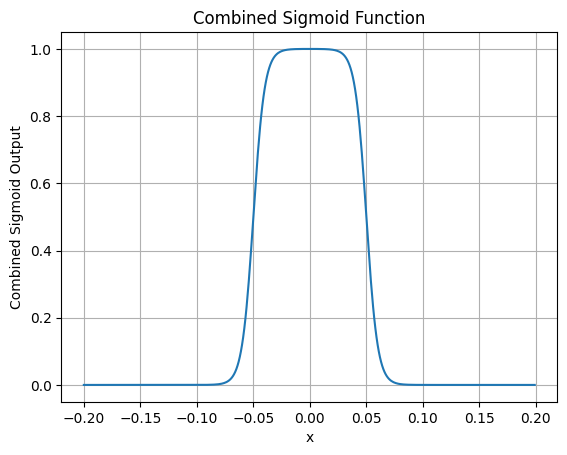

In [2]:
def combined_sigmoid_torch(x, window_center, window_width, stiffness=10):
    """
    Combine two sigmoid functions to produce a function close to 1 within a window
    and close to 0 outside the window.

    Parameters:
        x (torch.Tensor): Input tensor.
        window_center (float): Center of the window.
        window_width (float): Width of the window.
        stiffness (float, optional): Steepness of the sigmoid functions. Defaults to 10.

    Returns:
        torch.Tensor: Output tensor of the combined sigmoid function.
    """
    sigmoid_1 = torch.sigmoid(stiffness * (x - window_center + window_width / 2))
    sigmoid_2 = torch.sigmoid(stiffness * (x - window_center - window_width / 2))
    
    return sigmoid_1 * (1 - sigmoid_2)

class _args():
    def __init__(self) -> None:
        self.cam_stiffness = 200.
        self.cam_width = 0.1
        self.trainable_cam_parameters = False
args = _args()
x = torch.arange(-0.2, 0.2, 0.001)

# Example usage
window_center = 0.0
window_width = args.cam_width
stiffness = args.cam_stiffness
# window_width = 0.1
# stiffness = 10

y_values = combined_sigmoid_torch(x, window_center, window_width, stiffness=stiffness)

# Plotting

plt.plot(x.numpy(), y_values.numpy())
plt.xlabel('x')
plt.ylabel('Combined Sigmoid Output')
plt.title('Combined Sigmoid Function')
plt.grid(True)
plt.show()

Plotting a CAM output in function of window center and input

In [ ]:
# class CAMTransformer(nn.Module):
#     def __init__(self, dim_in, dim_out, center) -> None:
#         super().__init__()
#         self.cam = aCAM_NOR(dim_in, dim_out,                         
#                             stiffness=stiffness, 
#                             center=center,
#                             width=0.1,                                                       
#                             )
#     def forward(self, x):
#         x = self.cam(x.unsqueeze(0).unsqueeze(-1))
#         return x[0]

def tanh_approximation(x, y, stiffness):
    x = stiffness*(x-y)
    return x - x**3 / 3 # + 2*x**5 / 15 # - 17*x**7 / 315

def gaussian(x, y, width):
    x = (x-y)/width
    return torch.exp(-x**2)

def approx_gaussian(x, y, width):
    x = (x-y)/width
    return 2.0188/(1.2006+x**2) + 0.4473/(1.1776+x**2) - 3./(2.9089+x**2)

def approx_grad_gaussian(x, y, width):
    dif = (x-y)/width
    output = torch.zeros_like(dif).to(dif.device)
    sup_cond = torch.logical_and(dif>=0, dif<=1.)
    output[sup_cond] = - np.sqrt(np.log(2)) / (2*width) * (x[sup_cond] - y - width*np.sqrt(np.log(2)))
    inf_cond = torch.logical_and(dif<0, dif>=-1.)
    output[inf_cond] = + np.sqrt(np.log(2)) / (2*width) * (x[inf_cond] - y + width*np.sqrt(np.log(2)))
    else_cond = torch.logical_or(dif<-1., dif>1.)
    output[else_cond] = 0.
    return output

def CAM_approximation(x, y, stiffness=20., width=0.1):
    # out = (-(0.5*tanh_approximation(x, y-width/2, stiffness) - .5)) + ((0.5*tanh_approximation(x, y+width/2, stiffness) + .5))
    # return ((0.5*tanh_approximation(x, y+width/2, stiffness) + .5))
    # out =  (-(0.5*torch.tanh(stiffness * (x-(y-width/2))) - .5)) + ((0.5*torch.tanh(stiffness * (x-(y+width/2))) + .5))
    # return -(out-1)
    return gaussian(x, y, width), approx_gaussian(x, y, width), approx_grad_gaussian(x, y, width)

y = 0.0
net = CAMSimilarity(args)
out = net(x, y)
out_g, out_approx_g, out_approx_grad_g = CAM_approximation(x, y, width=width)
plt.figure()
plt.plot(x.detach(), out.detach())
# plt.plot(x.detach(), out_g.detach())
# plt.plot(x.detach(), out_approx_g.detach())
# plt.plot(x.detach(), out_approx_grad_g.detach())
plt.show()

Exponential decay of capacitor with time constant $\tau_{decay}=100µs$ and $\tau_{cycle}=20ns$

In [ ]:
n_steps = 50000
tau_cycle = 20e-9
tau_decay = 1e-4
k0 = 1.
time = torch.arange(0, n_steps)*tau_cycle

# Parallel method
k2 = k0 * torch.exp(-time / tau_decay)
fig, ax = plt.subplots()
ax.plot(time * 1000, k2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('K')

Iterative capacitor array writting correlation measurement

In [ ]:
from torchmetrics.regression import PearsonCorrCoef
tau_cycle = 20e-9 # duration of one read+write cycle
tau_decay = 5e-6 # capacitor decay time

n_steps = 2048*4 # number of cycles
M = 128 # number of capacitors array
D = 1024 # size of one capacitor array
capacitor = torch.zeros(n_steps, M, D)
signals = torch.rand(n_steps, D) # "signals" are the memory that we want to store in the capacitors (namely, either the keys or values)

decay = tau_cycle/tau_decay
decay = torch.clip(decay * (1 + torch.randn(M, D)*0.01), min=0., max=float('inf')) # simulating decay device-to-device variability
decay = (1-decay)

array_idx = 0
for t in range(n_steps):
    capacitor[t] = capacitor[t-1] * decay
    capacitor[t, array_idx] += signals[t]
    array_idx += 1
    array_idx = array_idx % M

# Measuring correlations of the array # array
array = 0
signals = signals[array::M].unsqueeze(0).expand(n_steps, -1, -1)
n_signals = signals[::M].shape[0]
correlations = torch.zeros(n_steps, n_signals)
for t in range(n_steps):
    # Pearson correlation coefficient    
    correlations[t] = PearsonCorrCoef(num_outputs = n_signals)(capacitor[t, array].unsqueeze(1).expand(-1, n_signals), signals[t].transpose(0,1))
    # Euclidian sim
    # correlations[t] = 1 / (1+torch.sqrt(torch.sum((signals[t] - capacitor[t, 0].unsqueeze(0)) ** 2, dim=1)))
    # Dot product
    # correlations[t] = (signals[t] @ capacitor[t, 0].unsqueeze(1)).squeeze()
    # Cosine similarity
    # correlations[t] = nn.CosineSimilarity(dim=1)(signals[t], capacitor[t, 0].unsqueeze(0))
# Correlation
# correlations, lags = scipy_autocorrelate(capacitor[:, 0].transpose(0,1), capacitor[:, 0].transpose(0,1), mode='same'), scipy_correlation_lags(len(capacitor[:, 0].transpose(0,1)), len(capacitor[:, 0].transpose(0,1)), mode='same')
# correlations = torch.sum(torch.tensor(correlations), dim=0)
    
time = torch.arange(0, n_steps)# * tau_cycle
fig, ax = plt.subplots(2)

ax[0].plot(time, capacitor[:, array].norm(dim=1))
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Capacitor norm')

colors = cm.magma

for s in range(n_signals):
# for s in range(1):
    # ax[1].plot(time*1e+6, correlations[:, s], label=f'signal #{s}')
    # ax[1].plot(time[0:63], correlations[0:63, s], label=f'signal #{s}')
    ax[1].plot(time[s*M:], correlations[s*M:, s], color = colors(s/n_signals), label=f'signal #{s}')
    
# ax.set_xlabel('Time (µs)')
ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Correlation')
# ax[1].legend()
fig.tight_layout() 
    

<!-- y = x CAM curve -->

In [ ]:
# x = torch.arange(-1, 1.01, 0.01)
# y = x
# out = torch.zeros_like(x)
# for j in range(x.shape[0]):
#     net = CAMTransformer(1, 1, center=y[j])
#     out[j] = net(x)[j]
#     # print(x[j])
#     # print(y[j])
# plt.figure()
# plt.plot(x.detach(), out.detach())
# plt.show()

Exponential product $e^{xy}$ similarity score curves

In [ ]:
class exp_score(nn.Module):
    def __init__(self, y) -> None:
        super().__init__()
        self.y = y
    def forward(self, x):
        return torch.exp(x*self.y)

x = torch.arange(-1, 1, 0.01)
y = torch.arange(-1,1.1,0.2)

colors = cm.coolwarm
fig = plt.figure()
for j in range(y.shape[0]):
    score = exp_score(y[j])
    out = score(x)
    plt.plot(x.detach(), out.detach(), c=colors(j/y.shape[0]), label=f'y={y[j]:.1f}')
fig.legend()
plt.show()


CAM similarity surface plot

In [ ]:
def CAM_surface_plot(y_bounds, elev, azim, roll):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    y_bounds

    x = torch.arange(y_bounds[0], y_bounds[1], 0.01)
    # y = x.clone()
    y = torch.arange(y_bounds[0], y_bounds[1], 0.01)
    Z = torch.zeros(x.shape[0], y.shape[0])
    for j in range(y.shape[0]):
        net = CAMTransformer(1, 1, center=y[j])
        Z[:, j] = net(x)
        
    # Plot the surface.
    X = x.unsqueeze(1).expand(-1, y.shape[0]).detach().cpu().numpy()

    Y = y.unsqueeze(1).expand(-1, x.shape[0]).transpose(0,1).detach().cpu().numpy()

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0,
                        antialiased=True,
                        )

    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(5))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.01f}')
    # Add a color bar which maps values to colors.
    fig.colorbar(surf,
                shrink=0.5,
                #  aspect=5
                )
    ax.set_xlabel('Q')
    ax.set_ylabel('K')
    ax.set_zlabel('Similarity')
    ax.set_title('$CAM(Q,K)$')
    
    ax.view_init(elev=elev, azim=azim, roll=roll)

    plt.show()
    

wb = widgets.interact(CAM_surface_plot,
                      y_bounds=widgets.FloatRangeSlider(value=[-1, 1], min=-2.0, max=2.0, step=0.1),
                      elev=widgets.FloatSlider(value=30, min=0, max=90, step=1),
                      azim=widgets.FloatSlider(value=30, min=-180, max=180, step=1),
                      roll=widgets.FloatSlider(value=0, min=-180, max=180, step=1),
                    )

Exponential product $e^{xy}$ similarity score surface

In [ ]:
def exp_score_surface_plot(y_bounds, elev, azim, roll):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    x = torch.arange(y_bounds[0], y_bounds[1], 0.01).unsqueeze(1)
    y = x.transpose(0,1) 
    Z = torch.exp(x*y)
    # Z /= torch.sum(Z, dim=-1).unsqueeze(1)
    X, Y, Z = x.detach().cpu().numpy(), y.detach().cpu().numpy(), Z.detach().cpu().numpy()

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                        #    linewidth=0,
                        antialiased=True,
                        )

    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(5))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.01f}')
    # Add a color bar which maps values to colors.
    fig.colorbar(surf,
                shrink=0.5,
                #  aspect=5
                )
    ax.set_xlabel('Q')
    ax.set_ylabel('K')
    ax.set_zlabel('Similarity')
    ax.set_title('$e^{QK}$')
    
    ax.view_init(elev=elev, azim=azim, roll=roll)

    plt.show()
    

wb = widgets.interact(exp_score_surface_plot,
                      y_bounds=widgets.FloatRangeSlider(value=[-1, 1], min=-2.0, max=2.0, step=0.1),
                      elev=widgets.FloatSlider(value=30, min=0, max=90, step=1),
                      azim=widgets.FloatSlider(value=30, min=-180, max=180, step=1),
                      roll=widgets.FloatSlider(value=0, min=-180, max=180, step=1),
                    )

Transistor function:

- $I_{DS}=0$ if $V_{GS}\leq V_{T}$
- $I_{DS}=\mu_{n}C_{ox}\frac{W}{L}\left[\left(V_{GS}-V_{T}\right)V_{DS}-\frac{V_{DS}^{2}}{2}\right]\left(1+\lambda V_{DS}\right)$ if $V_{GS}\geq V_{T}$, $V_{DS}\leq V_{GS}-V_{T}$
- $I_{DS}=\frac{1}{2}\mu_{n}C_{ox}\frac{W}{L}\left(V_{GS}-V_{T}\right)^{2}\left(1+\lambda V_{DS}\right)$ if $V_{GS}\geq V_{T}$, $V_{DS}> V_{GS}-V_{T}$

Let's call:
- $\gamma = \mu_{n}C_{ox}\frac{W}{L}$ -> The conductance per volt. Typically $\gamma$ = 100 µS/V (we normalize to $\gamma$ = 1 to get normal output values)
- $\lambda$ = 0.05 V
- $x = V_{DS}$ is the input
- $w = V_{GS}$ is the weight (stored in a capacitor)

https://inst.eecs.berkeley.edu/~ee105/fa05/handouts/discussions/Discussion5.pdf

In [ ]:
v_th = 0.0 # V threshold
v_ds_min = 0.0
v_ds_max = 1.0

v_gs_min = 0.0
v_gs_max = 1.0

_gamma = 1.
_lambda = 0.05

def transistor_model(x, w, v_th=.5, _gamma=1., _lambda=.05):
    over_threshold = w > v_th
    lin_cond = (x - (w-v_th) <= 0) * over_threshold
    sat_cond = (x - (w-v_th) > 0) * over_threshold # Saturated when the input voltage is larger that the overdrive and overdrive positive
    w = w.expand_as(lin_cond)
    x = x.expand_as(lin_cond)
    out = torch.zeros_like(lin_cond, dtype=torch.float, device=x.device)
    out[lin_cond] = ((w[lin_cond] - v_th)*x[lin_cond] - x[lin_cond]**2/2) * (1 + _lambda*x[lin_cond])
    out[sat_cond] = 1/2 * (w[sat_cond] - v_th)**2 * (1 + _lambda*x[sat_cond])
    # out = ((w - v_th)*x - x**2/2) * (1 + _lambda*x)
    # out = ((w - v_th)*x) * (1 + _lambda*x)
    # out = (w - v_th)*x - x**2/2
    pre_sum = out
    out = torch.sum(out, dim=-2)#.unsqueeze(-1).expand(-1,-1,D)
    out = out * _gamma
    return out, pre_sum

fig, ax = plt.subplots(3)
fig.set_figwidth(9)
fig.set_figheight(18)

# Sweep input for multiple weights
x = torch.linspace(v_ds_min, v_ds_max, 100).unsqueeze(0).unsqueeze(0)
w = torch.linspace(v_gs_min, v_gs_max, 10).unsqueeze(-1).unsqueeze(-1)
out, _ = transistor_model(x, w, v_th, _gamma, _lambda)
colors = cm.coolwarm

for i in range(out.shape[0]):
    ax[0].plot(x.squeeze(), out[i], c=colors(i/out.shape[0]), linewidth=2)    
w_sat = x + v_th # Saturation limit
out_sat, _ = transistor_model(x, w_sat, v_th, _gamma, _lambda)
ax[0].plot(x.squeeze(), out_sat.squeeze(), '--k', linewidth=2)
ax[0].set_xlabel('$V_{DS}$')
ax[0].set_ylabel('$I_{out}$')

for i in range(out.shape[1]//10):
    ax[1].plot(w.squeeze(), out[:, i*10], c=colors(i/(out.shape[1]//10)), linewidth=2)
x_sat = w - v_th # Saturation limit
out_sat, _ = transistor_model(x_sat, w, v_th, _gamma, _lambda)
ax[1].plot(w.squeeze(), out_sat.squeeze(), '--k', linewidth=2)
ax[1].set_xlabel('$V_{GS}$')
ax[1].set_ylabel('$I_{out}$')

# Many inputs and weights
T = 1024 # number of tokens
D = 64 # feature dimension
M = 128  # time memory dimension
x = torch.rand(T, M, D) * (v_ds_max - v_ds_min) + v_ds_min
w = torch.rand(T, M, 1) * (v_gs_max - v_gs_min) + v_gs_min
out, pre_sum = transistor_model(x, w, v_th, _gamma, _lambda)

# Sweep both input and weights
ax[2].scatter(_gamma * (x * (w-v_th)).sum(dim=1).flatten(), out.flatten(), s=1, c='darkblue')

# Fit
# linearized_xw = _gamma * (x * (w-v_th)).sum(dim=1).flatten()
# def linear_fit(x, a, b):
#     return a + b * x
# popt, pcov = curve_fit(linear_fit, linearized_xw.numpy(), out.flatten().numpy())
# print(popt)
linearized_xw = _gamma * (x * (w-v_th)).flatten()
pre_sum = pre_sum.flatten()
def linear_fit(x, a, b):
    return a + b * x
popt, pcov = curve_fit(linear_fit, linearized_xw.numpy(), pre_sum.numpy())
print(popt)

popt = tuple(popt)
out = linear_fit(linearized_xw, *popt)
out = torch.tensor(out).reshape(T, M, D).sum(dim=-2).flatten()
linearized_xw = torch.tensor(linearized_xw).reshape(T, M, D).sum(dim=-2).flatten()
ax[2].plot(linearized_xw, out, 'r--',linewidth=2)

ax[2].set_xlabel('$\gamma V_{GS}V_{DS}$')
ax[2].set_ylabel('$I_{out}$')

# Sweeping the weights for a single input feature dim
# ax[2].scatter((w[:,:,0]).flatten(), out[:,:,0].flatten(), s=1, c='darkblue')
# ax[2].set_xlabel('$V_{GS}$')
# ax[2].set_ylabel('$I_{out}$')

fig.tight_layout()


Paul's simulation data for transistors

In [ ]:
#load with numpy.load
data = np.load("transistor.npy",allow_pickle=True)
Vds = data.item().get("Vds")
Vgs = data.item().get("Vgs")
Ids = data.item().get("Ids")
Ids *= 1000

vds_min = -0.21
vds_max = 0.21

vgs_min = 0.5
vgs_max = 1.1

VGS_vals = np.linspace(0,99,10)
fig, ax = plt.subplots(2)
fig.set_figwidth(7)
fig.set_figheight(11)
cmap=cm.coolwarm
for i, VGS_index in enumerate(VGS_vals):
    if Vgs[int(VGS_index)] < vgs_max and Vgs[int(VGS_index)] > vgs_min:
        ax[0].plot(Vds, Ids[int(VGS_index),:], 'o', ms=5, label=f'Vgs={Vgs[int(VGS_index)]:.2f}', c=cmap(i/len(VGS_vals)))
# ax[0].legend()
ax[0].set_xlabel("Vds [V]")
ax[0].set_ylabel("Ids [mA]")

VDS_vals = np.linspace(0,99,10)
for VDS_index in VDS_vals:
    ax[1].plot(Vgs, Ids[:, int(VDS_index)], 'o', ms=5, label="Vds="+str(Vds[int(VDS_index)]))
# ax[1].legend()
ax[1].set_xlabel("Vgs [V]")
ax[1].set_ylabel("Ids [mA]")
fig.tight_layout()

#surface plot of the current
Vds3d, Vgs3d = np.meshgrid(Vds, Vgs)
fig = plt.figure()
ax3d = plt.axes(projection ='3d')
surf = ax3d.plot_surface(Vds3d, Vgs3d, Ids, cmap=cm.coolwarm)
ax3d.set_xlabel("Vds [V]")
ax3d.set_ylabel("Vgs [V]")
ax3d.set_zlabel("I [mA]")
ax3d.set_title("Current")

# fit the curves
def transistor_polynomial(xy, a, b, c, d, e, f,
                          g,
                          h,
                          i,
                          j,
                          ):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y + g*x**3 + h*y**3 + i*x**2*y + j*x*y**2

condition = (Vds3d < vds_max) * (Vds3d > vds_min) * (Vgs3d < vgs_max) * (Vgs3d > vgs_min)
n_args = len(getargspec(transistor_polynomial).args) - 1
popt, pcov = curve_fit(transistor_polynomial, (Vds3d[condition].flatten(), Vgs3d[condition].flatten()), Ids[condition].flatten(),
                       bounds=(np.concatenate((np.array([-1e-8]), np.array([-np.inf for i in range(n_args-1)]))), np.concatenate((np.array([+1e-8]), np.array([+np.inf for i in range(n_args-1)])))),
                       )

popt = tuple(popt)
Ids_fit = transistor_polynomial((Vds3d.flatten(), Vgs3d.flatten()), *popt)
Ids_fit = Ids_fit.reshape((100,101))

for i, VGS_index in enumerate(VGS_vals):
    if Vgs[int(VGS_index)] < vgs_max and Vgs[int(VGS_index)] > vgs_min:
        ax[0].plot(Vds, Ids_fit[int(VGS_index),:], '-', linewidth=2, c=cmap(i/len(VGS_vals)))
ax[0].set_xlim([vds_min, vds_max])
ax[0].set_ylim([-0.1, 0.1])
ax[0].legend()
ax[0].set_xlabel("Vds [V]")
ax[0].set_ylabel("Ids [mA]")
print(popt)

plt.show()